In [1]:
import sys
import os

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

sys.path.insert(
    2,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/pinn"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc, skew, kurtosis
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian
from matplotlib.ticker import ScalarFormatter

from utils import set_global_seed, get_esd_plot, density_generate, gaussian,\
                    mean_gradient, absolute_max_gradient, grad_norm, FFE
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

In [2]:
# Define and fix seed
SEED: int = 0
set_global_seed(SEED)
print(f"Seed set: {SEED}")

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "damping"
VARYING_PARAM_NOTATION: str = "$d$"

print(f"Parameter: {VARYING_PARAM}")

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Param dictionary
PARAM_DICT = {
    "DAMPING": [0.00015, 0.0015, 0.015, 0.15, 1.5],
    "INERTIA": [0.01, 0.1325, 0.250, 0.3775, 0.5],
    "PHYSICS_WEIGHT": [1e-2, 1e-1, 1e0, 1e1, 1e2],
    "MECHANICAL_POWER": [0.0, 0.0475, 0.095 , 0.1425, 0.19]
}

# Specify the range of parameter values
PARAM_LIST: list[float] = PARAM_DICT[VARYING_PARAM.upper()]

# DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])
PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
IC_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[0.13]])

DATA_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])

# Specify FFE parameters
FFE_SIGMA: int = 3
FFE_M: int = 5

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                        f"/dissertation_code/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

SAVE: bool = False

# Toggle flag on whether or not to implement the R3 algorithm proposed by Daw et al. 2023
R3_ALGO: bool = False

# Toggle flag on whether or not to implement the adaptive weight algorithm proposed by Wang et al. 2020
ADAPTIVE_ALGO: bool = True

# Toggle flag on whether or not to implement semi-supervised learning
DATA_LOSS: bool = False

print(f"Plots and files are exported from this file?\t{SAVE}")
print(f"R3 algorithm enabled?\t{R3_ALGO}")
print(f"Adaptive loss weight algorithm enabled?\t{ADAPTIVE_ALGO}")
print(f"Semi-supervised learning enabled?\t{DATA_LOSS}")

# if R3_ALGO:
#     IC_WEIGHT: torch.Tensor = torch.tensor(data=[[100.0]])

Seed set: 0
Parameter: damping
Plots and files are exported from this file?	False
R3 algorithm enabled?	False
Adaptive loss weight algorithm enabled?	True
Semi-supervised learning enabled?	False


In [3]:
print(f"IC weight: {IC_WEIGHT.item()}")
print(f"Data weight: {DATA_WEIGHT.item()}")

if VARYING_PARAM != "physics_weight":
    print(f"Physics weight: {PHYSICS_WEIGHT.item()}")

IC weight: 1.0
Data weight: 1.0
Physics weight: 1.0


In [4]:
# Ensure desired folder has all intended subdirectories to store the results in
parent_dir = f"{PATH_TO_IM_DIR}/pinn/"
required_subdirs = ["l2_errors", "pinn_pred_vs_rk45", "rel_error_per_epoch", "training_loss", "gradient_norms", "l2_errors/semi_supervised"]

for subdir in required_subdirs:
    full_path = os.path.join(parent_dir, subdir)
    if not os.path.exists(full_path):
        os.makedirs(full_path, exist_ok=True)
        print(f"Created: {full_path}")
    else:
        print(f"Already exists: {full_path}")

Already exists: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/damping//pinn/l2_errors
Already exists: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/damping//pinn/pinn_pred_vs_rk45
Already exists: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/damping//pinn/rel_error_per_epoch
Already exists: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/damping//pinn/training_loss
Already exists: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/damping//pinn/gradient_norms
Already exists: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/data/visualisations/loss_landscapes/damping//pinn

In [5]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
# DEVICE: str = torch.device("mps" if torch.backends.mps.is_available else "cpu")
DEVICE: str = "cpu"

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 1_000

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float32).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 0.01
LEARNING_RATE_LBFGS: float = 1.0

# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9
HISTORY: int = 100

EPOCHS: int = 15_000
EPOCHS_ADAM: int = 10_000
N_C: int = 1_000  # Number of collocation points
print(f"Number of collocation points: {N_C}")
print(f"Number of total epochs: {EPOCHS}")
print(f"Number of Adam epochs: {EPOCHS_ADAM}")

# Specify activation function
ACTIVATION: str = "tanh"

# Specify the number of hidden units per layer
HIDDEN_UNITS: int = 10
print(f"Number of hidden units per layer: {HIDDEN_UNITS}")

# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1, seed=SEED)
collocation_points = LHC.random(n=N_C)
collocation_points = qmc.scale(
    collocation_points, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

collocation_points: torch.tensor = torch.tensor(
    data=collocation_points[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)

print(torch.sum(collocation_points))

Number of collocation points: 1000
Number of total epochs: 15000
Number of Adam epochs: 10000
Number of hidden units per layer: 10
tensor(9999.6621, grad_fn=<SumBackward0>)


In [6]:
feature_vector = FFE_SIGMA*torch.randn(FFE_M).unsqueeze(dim=1)
FFE_collocation_points = FFE(original_input=collocation_points, frequency_vector=feature_vector)
print(f"FFE shape: {FFE_collocation_points.shape}")

FFE shape: torch.Size([1000, 11])


## This cell contains a parameter which must be changed

In [7]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)
print(f"Total number of data points from RK45, N = {N}")

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.2
print(f"Percentage of data to be used for training: {TRAIN_TEST_SPLIT * 100}%")

for param in PARAM_LIST:

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact, dtype=torch.float32).to(device=DEVICE)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy, dtype=torch.float32).to(device=DEVICE)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True).to(device=DEVICE)
times_tensor_FFE = FFE(original_input=times_tensor, frequency_vector=feature_vector)

# Obtain a random array of index to index the numerical solution on to obtain training data
# for vanilla NN
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)
print(f"Number of training points: {rand_index.shape[0]}")

Total number of data points from RK45, N = 201
Percentage of data to be used for training: 20.0%
Number of training points: 41


In [8]:
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)
assert int(test_indices.shape[0] + rand_index.shape[0]) == N

In [9]:
if DATA_LOSS:

    supervised_training_phase_angle = numerical_solutions_noisy_tensor[:, 0, tuple(rand_index)].clone().unsqueeze(1).T
    supervised_training_angular_frequency = numerical_solutions_noisy_tensor[:, 1, tuple(rand_index)].clone().unsqueeze(1).T
    
    supervised_times_dummy = times_tensor.clone().detach().requires_grad_(False)
    supervised_input = supervised_times_dummy[tuple(rand_index), None].squeeze(dim=1)
  
    fig, ax = plt.subplots(1, 2)

    ax[0].scatter(numerical_domain, numerical_solutions_exact[-2, 0, :], marker='.')
    ax[0].scatter(supervised_input.detach().numpy(), supervised_training_phase_angle[:, :, -2].detach().numpy(), color="red", marker='.')
    
    ax[1].scatter(numerical_domain, numerical_solutions_exact[-2, 1, :], marker='.')
    ax[1].scatter(supervised_input.detach().numpy(), supervised_training_angular_frequency[:, :, -2].detach().numpy(), color="red", marker='.')

    plt.show()

    print(supervised_training_phase_angle.shape)

In [10]:
# Define subspace mesh
LB: int = -2
NUM_VERTICES: int = 40
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION, hidden_units=HIDDEN_UNITS, no_of_inputs=2*FFE_M+1).to(device=DEVICE)).total_params
print(f"Total number of learnable parameters: {TOTAL_NUM_PARAMS}\n")

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-6
assert torch.norm(input=direction_vec_2) - 1 < 1e-6

print(torch.sum(direction_vec_1))
print(torch.sum(direction_vec_2))

Total number of learnable parameters: 900

tensor(-0.9114)
tensor(-0.2166)


In [11]:
def IC_based_loss(model: Callable, initial_state: torch.Tensor, device: str) -> torch.Tensor:
    """
    Computes IC loss/regularisation term for pre-specified ICs
    for a single training example.

    Parameters
    ----------
    model : Callable
        The PINN
    initial_states : torch.Tensor
        Pre-specified initial state of the system
    device : str
        Device to move the tensors to (CPU or GPU)

    Returns
    -------
    error : float
        IC-based loss for a single training example
    """

    # Compute the square of the l2 norm between the PINN prediction at t=0 and the
    # initial state

    initial_state = initial_state.clone().detach()

    t0 = torch.tensor(data=[[0.0]], requires_grad=True).to(device=device)

    t0_FFE = FFE(original_input=t0, frequency_vector=feature_vector)

    initial_phase_angle = model.forward(t0_FFE)

    initial_angular_frequency = torch.autograd.grad(
        outputs=initial_phase_angle,
        inputs=t0,
        grad_outputs=torch.ones_like(initial_phase_angle),
        create_graph=True,
    )[0]

    initial_pred = torch.cat(
        tensors=[initial_phase_angle, initial_angular_frequency], dim=1
    )

    error: float = torch.norm(input=initial_pred - initial_state) ** 2

    assert error.requires_grad is True

    return error


In [12]:
def physics_based_loss(model: Callable, input: torch.Tensor) -> float:
    """
    Computes ODE residual regularisation term for a single training example.

    Parameters
    ----------
    swing_inputs : NamedTuple
        NamedTuple of ODE parameters, solution and deriatives
    include_controllers : bool
        Boolean arguement to determine whether or not controllers should be included

    Returns
    -------
    error: The physics-based loss for a single training example
    """
    
    # input = input.clone().detach().requires_grad_(True)

    phase_angle_pred = model.forward(data=input)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=input,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=input,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Compute the total electrical power output generator k supplies to the grid
    total_electrical_output = 0
    for v, delta, B in zip(
        VOLTAGES, PHASE_ANGLES, SUSCEPTANCES
    ):
        total_electrical_output += (
            B
            * VOLTAGE
            * v
            * torch.sin(phase_angle_pred - delta)
        )

    # # Compute the cost based on whether or not PI controllers are accounted for
    # if include_controllers:
    #     cost: float = (
    #         (swing_inputs.inertia * swing_inputs.angular_acceleration)
    #         + (swing_inputs.damping - swing_inputs.controller_proportional)
    #         * swing_inputs.angular_frequency
    #         + total_electrical_output
    #         - (swing_inputs.controller_integral * swing_inputs.phase_angle)
    #     )

    #     # No **2 to prevent invoking expensive microcode in each iteration of the training
    #     error: float = torch.mean(input=cost * cost)
    #     return error
    
    cost: float = (
        (INERTIA * angular_acceleration_pred)
        + (DAMPING * angular_frequency_pred)
        + total_electrical_output
        - MECHANICAL_POWER
    )

    # No **2 to prevent invoking expensive microcode in each iteration of the training
    error: float = torch.mean(input=cost * cost)
    return error

In [13]:
def R3_algorithm(collocation_set: torch.Tensor, model: Callable, n: int, epoch: int, **kwargs) -> torch.Tensor:
        
    """
    Implements the R3 (retain-release-resample) sampling algorithm proposed by Daw
    et al. 2023 (https://arxiv.org/abs/2207.02338).
    """

    # assert collocation_set.requires_grad is True

    if epoch % n == 0:
        residual_array = []

        model.eval()

        for t in collocation_set:
            t_fresh = t.clone().detach().requires_grad_(True) 
            residual = physics_based_loss(model=model, input=t_fresh)
            residual_array.append(torch.abs(residual).detach())
            
        residual_tensor = torch.stack(residual_array)
        threshold = torch.mean(residual_tensor.detach())

        # Retain points above threshold
        retained = collocation_set[residual_tensor > threshold]
        retained = retained.clone().detach().requires_grad_(True) 

        # Resample new ones
        n_to_sample = N_C - retained.shape[0]
        new_samples = torch.zeros(n_to_sample, 1, dtype=torch.float32, device=DEVICE).uniform_(0.0, 20.0)
        # new_samples = (T0 - FINALTIME) * torch.rand((n_to_sample, 1), device=DEVICE, requires_grad=True) + FINALTIME

        collocation_next_epoch = torch.cat([retained, new_samples], dim=0)
        collocation_next_epoch = collocation_next_epoch.clone().detach().requires_grad_(True)

        assert collocation_next_epoch.shape == (N_C, 1)
        assert collocation_next_epoch.requires_grad is True
        
        model.train()
        return collocation_next_epoch
    else:
        return collocation_set

## The cell below implements the adaptive loss term weight algorithm proposed by Wang et al. 2020.

In [14]:
def adaptive_weights(
    model: Callable, epoch: int, n: int, alpha: float, ic_weight: torch.Tensor,
    physics_weight: torch.Tensor, res_loss: torch.Tensor, data_loss: torch.Tensor,
    max_data_grad_list: list[float], mean_residual_grad_list: list[float],
    algorithm: str, epsilon: float = 1e-12) -> None:

    """
    Implements the adaptive loss term weight algorithm proposed by Wang
    et al. 2020 (https://arxiv.org/abs/2207.02338) and Wang et al. 2023
    (https://arxiv.org/abs/2308.08468).
    """

    if epoch % n == 0:
        
        # learnable_params = [param for param in model.parameters() if param.requires_grad]
        grad_res = torch.autograd.grad(res_loss, model.parameters(), retain_graph=True, create_graph=False)
        grad_data = torch.autograd.grad(data_loss, model.parameters(), retain_graph=True, create_graph=False)

        if algorithm.lower() == "wang_2020":

            # Compute adaptive physics weight
            grad_data_max = absolute_max_gradient(grad_data)
            grad_res_mean = mean_gradient(grad_res)
            lambda_physics_hat = (grad_data_max / (grad_res_mean + epsilon)).detach()

            max_data_grad_list.append(grad_data_max)
            mean_residual_grad_list.append(grad_res_mean)

            with torch.no_grad():
                physics_weight.mul_(1 - alpha).add_(alpha * lambda_physics_hat)
                # ic_weight.mul_(1 - alpha).add_(alpha * lambda_ic_hat)
        
        elif algorithm.lower() == "wang_2023":

            grad_norm_data = grad_norm(model=model, loss=data_loss)
            grad_norm_physics = grad_norm(model=model, loss=res_loss)

            lambda_physics_hat = ((grad_norm_physics+grad_norm_data)/(grad_norm_physics)).detach()
            lambda_data_hat = ((grad_norm_physics+grad_norm_data)/(grad_norm_data)).detach()

            with torch.no_grad():
                physics_weight.mul_(1 - alpha).add_(alpha * lambda_physics_hat)
                ic_weight.mul_(1 - alpha).add_(alpha * lambda_data_hat)
    
    else:
        pass

In [15]:
# Collect all trained PINN models for each parameter
pinn_models = []

# Collect training losses across each parameter value
training_losses_per_param = []

# Collect residual losses across each parameter value
residual_losses_per_param = []

# Collect IC losses across each parameter value
IC_losses_per_param = []

# Collect test losses per epoch across each parameter
test_losses_per_param_per_epoch = []

# Collect summary statistics of the distribution of residual values per epoch per parameter
skewness_per_param = []
kurtosis_per_param = []

# Collect 2-norm of gradients of loss wrt weights/biases for each parameter per epoch
gradient_norm_per_param = []



# Collect residual and data loss gradient norms per param
grad_norm_res_per_param = []
grad_norm_data_per_param = []

# Collect the collocation set at the LAST epoch, updated by the R3 algorithm
collocation_points_R3 = []

# Obtain a list of initial weights for the PINNs for each param
initial_params_pinn_models = None

# Define lists for the adaptive weight algorithm by Wang et al. 2020
max_gradients_per_param = []
mean_gradients_per_param = []
# Collect weights per adaptive weight update
adaptive_weights_per_n_epochs_per_param = []

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    set_global_seed(SEED)

    print(f"Param value {index+1}")
    print("----------------------\n")

    ######################################################
    # SPECIFY VARIABLE PARAMETER
    ######################################################
    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Reset lambda_IC to original value for each param
    if ADAPTIVE_ALGO:
        PHYSICS_WEIGHT = torch.tensor(data=[[1.0]])
        IC_WEIGHT = torch.tensor(data=[[1.0]])
        assert PHYSICS_WEIGHT.item() == 1.0 and IC_WEIGHT.item() == 1.0

    # Reset the initial collocation set for each parameter iteration
    collocation_points_clone = FFE_collocation_points.clone().detach().requires_grad_(True)

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION, hidden_units=HIDDEN_UNITS, no_of_inputs=FFE_M*2+1).to(device=DEVICE)

    # Obtain and extract initialisation parameters of pinn before any training
    if index == 0:
        initial_params_pinn_models = parameters_to_vector(pinn.parameters()).clone().detach()

    total_sum = sum(p.sum().item() for p in pinn.parameters())
    print(f"Sum of all weights: {total_sum:.6f}")

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser_adam = torch.optim.Adam(params=pinn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser_adam, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    optimiser_lbfgs = torch.optim.LBFGS(
        params=pinn.parameters(),
        lr=LEARNING_RATE_LBFGS,
        history_size=HISTORY,
        line_search_fn="strong_wolfe",
        max_iter=100_000,
        max_eval=100_000,
        tolerance_change= np.finfo(float).eps
    )

    def closure():
        optimiser_lbfgs.zero_grad()
        residual_loss = physics_based_loss(model=pinn, input=collocation_points_clone.clone().detach().requires_grad_(True))
        ic_loss = IC_based_loss(model=pinn, initial_state=INITIAL_STATE, device=DEVICE)

        if DATA_LOSS:
            supervised_pred = pinn.forward(data=supervised_input)
            data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss + DATA_WEIGHT * data_loss
        else:
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss
            
        loss.backward()
        return loss
    
    if DATA_LOSS:
        supervised_mse = torch.nn.MSELoss()

    # Define list to collect total training loss every epoch
    training_loss = []

    # Define list to collect residual loss every epoch
    residual_loss = []

    # Define list to collect IC loss every epoch
    ic_loss = []

    # Define list to collect test losses every epoch (L2 relative error)
    test_loss = []

    # Define two lists to collect skewness and kurtosis values per epoch of the residual loss distributions
    kurtosis_list = []
    skewness_list = []

    # Obtain PINN rediction at current state for test set and evaluate performance
    ground_truth_phase_angle = numerical_solutions_exact_tensor[index, 0, :]
    ground_truth_angular_frequency = numerical_solutions_exact_tensor[index, 1, :]

    # Define list to collect 2-norm of the gradient of the loss wrt the params every epoch
    # ADAM only
    gradient_norm = []
    res_gradient_norm = []
    data_gradient_norm = []

    # Define lists for the Adaptive Weight Algorithm by Wang et al. 2020
    adaptive_weights_per_n_epochs = []
    max_gradients = []
    mean_gradients = []

    # Perform the training loop using full-batch training
    for epoch in (range(1, EPOCHS+1)):
        
        pinn.eval()
        phase_angle_pred_test = pinn.forward(data=times_tensor_FFE, initial_state=INITIAL_STATE)

        pinn.train()
        angular_frequency_pred_test = torch.autograd.grad(
            outputs=phase_angle_pred_test,
            inputs=times_tensor,
            grad_outputs=torch.ones_like(phase_angle_pred_test),
            create_graph=False,
            retain_graph=True
        )[0]

        pred_vector = torch.stack(tensors=(phase_angle_pred_test, angular_frequency_pred_test), dim=0).squeeze()
        label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0)

        _, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)
        test_loss.append(l2_rel.item())

        if R3_ALGO and epoch <= EPOCHS_ADAM:

            # Deploy the R3 algorithm proposed by Daw et al. 2023
            collocation_points_clone = R3_algorithm(
                collocation_set=collocation_points_clone,
                model=pinn,
                n=50,
                epoch=epoch
            )
            
            if epoch == EPOCHS_ADAM:
                collocation_points_R3.append(collocation_points_clone.detach().numpy())
        
        # Obtain losses
        ode_loss = physics_based_loss(model=pinn, input=collocation_points_clone.clone().detach().requires_grad_(True))
        initial_cond_loss = IC_based_loss(model=pinn, initial_state=INITIAL_STATE, device=DEVICE)

        # Use the adaptive weights algorithm from Wang et al. 2020
        if (ADAPTIVE_ALGO is True) and (epoch <= EPOCHS_ADAM):

            adaptive_weights(
                model=pinn,
                epoch=epoch,
                n=10,           # Default number of epochs as set in the original paper
                alpha=0.90,
                res_loss=ode_loss,
                data_loss=initial_cond_loss,
                physics_weight=PHYSICS_WEIGHT,
                ic_weight=IC_WEIGHT,
                max_data_grad_list=max_gradients,
                mean_residual_grad_list=mean_gradients,
                algorithm="wang_2023"
            )

            adaptive_weights_per_n_epochs.append((PHYSICS_WEIGHT.detach().item(), IC_WEIGHT.detach().item()))

        res_gradient_norm.append(grad_norm(model=pinn, loss=ode_loss))
        data_gradient_norm.append(grad_norm(model=pinn, loss=initial_cond_loss))

        if DATA_LOSS:
            supervised_pred = pinn.forward(data=supervised_input)
            data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
            loss = (PHYSICS_WEIGHT.detach() * ode_loss) + (IC_WEIGHT.detach() * initial_cond_loss) + (DATA_WEIGHT * data_loss)

        else:
            loss = (PHYSICS_WEIGHT.detach() * ode_loss) + (IC_WEIGHT.detach() * initial_cond_loss)

        residual_loss.append(ode_loss.detach().item())
        ic_loss.append(initial_cond_loss.detach().item())

        # Obtain the total loss and backpropogate on that value
        training_loss.append(loss.detach().item())

        if epoch == 1:
            print(
                f"Initial training loss: {loss.detach().item()}\t\t"\
                f"Initial residual loss: {ode_loss.detach().item()}\t\t"\
                f"Initial IC loss: {initial_cond_loss.detach().item()}\t\t"
            )

        # Backpropogate using reverse/backward-mode AD
        if epoch <= EPOCHS_ADAM:
            optimiser_adam.zero_grad()
            loss.backward()

            total_norm = 0
            total_num_params = 0
            for w_n_b in pinn.parameters():
                if w_n_b.grad is not None:
                    total_num_params += w_n_b.flatten().shape[0]
                    param_norm = w_n_b.grad.detach().norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norm.append(total_norm)

            assert total_num_params == TOTAL_NUM_PARAMS

            optimiser_adam.step()
            lr_scheduler.step(metrics=loss)

            if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
                if DATA_LOSS:
                    print(
                    f"{VARYING_PARAM_NOTATION}={param:.2e}\t\t"\
                    f"Epoch: {epoch}\t\t"\
                    f"Training loss: {loss.item()}\t\t"\
                    f"Residual loss: {ode_loss.detach().item()}\t\t"\
                    f"IC loss: {initial_cond_loss.detach().item()}\t\t"\
                    f"Data loss: {data_loss.detach().item()}\t\t"\
                    )
                else:
                    print(
                    f"{VARYING_PARAM_NOTATION}={param:.2e}\t\t"\
                    f"Epoch: {epoch}\t\t"\
                    f"Training loss: {loss.item()}\t\t"\
                    f"Residual loss: {ode_loss.detach().item()}\t\t"\
                    f"IC loss: {initial_cond_loss.detach().item()}\t\t"
                    )

        else:
            optimiser_lbfgs.step(closure=closure)
            
            if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
                print(f"{VARYING_PARAM_NOTATION}={param:.2e}\t\tEpoch: {epoch}\t\tRunning L-BFGS")
    
    # Append the trained model and the training losses per epoch to the respective lists
    pinn_models.append(pinn)
    training_losses_per_param.append(training_loss)
    residual_losses_per_param.append(residual_loss)
    IC_losses_per_param.append(ic_loss)
    test_losses_per_param_per_epoch.append(test_loss)
    # skewness_per_param.append(skewness_list)
    # kurtosis_per_param.append(kurtosis_list)
    gradient_norm_per_param.append(gradient_norm)
    grad_norm_res_per_param.append(res_gradient_norm)
    grad_norm_data_per_param.append(data_gradient_norm)

    adaptive_weights_per_n_epochs_per_param.append(adaptive_weights_per_n_epochs)
    max_gradients_per_param.append(max_gradients)
    mean_gradients_per_param.append(mean_gradients)


Param value 1
----------------------

Sum of all weights: -0.173499
Initial training loss: 2.0386345386505127		Initial residual loss: 0.011650633066892624		Initial IC loss: 2.0269839763641357		
$d$=1.50e-04		Epoch: 1000		Training loss: 0.0005859092925675213		Residual loss: 7.891834684414789e-05		IC loss: 1.0010611504185363e-06		
$d$=1.50e-04		Epoch: 2000		Training loss: 0.0002719717740546912		Residual loss: 6.348019087454304e-05		IC loss: 1.6946354719493684e-07		
$d$=1.50e-04		Epoch: 3000		Training loss: 0.0001777500001480803		Residual loss: 5.594926551566459e-05		IC loss: 5.815854464685799e-08		
$d$=1.50e-04		Epoch: 4000		Training loss: 0.00012119727034587413		Residual loss: 5.26290932612028e-05		IC loss: 1.8410721835948607e-08		
$d$=1.50e-04		Epoch: 5000		Training loss: 9.521120955469087e-05		Residual loss: 5.034742207499221e-05		IC loss: 7.871475027343422e-09		
$d$=1.50e-04		Epoch: 6000		Training loss: 7.818239828338847e-05		Residual loss: 4.9271551688434556e-05		IC loss: 3.26770233

In [16]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []

# Iterate over all parameter values
for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    model.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(model.parameters()).clone().detach()

    # Define lists to collect the loss landscapes for random directions
    loss_landscape_random = []
    
    supervised_mse = torch.nn.MSELoss()

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)
            assert perturbation.shape[0] == TOTAL_NUM_PARAMS

            vector_to_parameters(vec=perturbation, parameters=model.parameters())

            # Obtain losses
            if R3_ALGO:
                ode_loss = physics_based_loss(model=model, input=collocation_points_R3[index].clone().detach().requires_grad_(True))
            else:
                ode_loss = physics_based_loss(model=model, input=collocation_points_clone.clone().detach().requires_grad_(True))
                
            ic_loss = IC_based_loss(model=model, initial_state=INITIAL_STATE, device=DEVICE)

            if ADAPTIVE_ALGO:
                loss_perturb_random = adaptive_weights_per_n_epochs_per_param[index][-1][0] * ode_loss + adaptive_weights_per_n_epochs_per_param[index][-1][1] * ic_loss
            else:
                loss_perturb_random = PHYSICS_WEIGHT*ode_loss + IC_WEIGHT*ic_loss

            if DATA_LOSS:
                supervised_pred = model.forward(data=supervised_input)
                data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
                loss_perturb_random += DATA_WEIGHT * data_loss

            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=model.parameters())

    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

    assert torch.allclose(MINIMISER, parameters_to_vector(model.parameters()).clone().detach())

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [17]:
def loss_closure(model: Callable, input: torch.Tensor, initial_state: torch.Tensor):

    def loss_function(inputs: torch.Tensor, targets: torch.Tensor) -> float:

        residual_loss = physics_based_loss(model=model, input=input)
        ic_loss = IC_based_loss(model=model, initial_state=initial_state, device="cpu")

        if DATA_LOSS:
            supervised_pred = model.forward(data=supervised_input)
            data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss + DATA_WEIGHT * data_loss
        else:
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss

        return loss
    
    return loss_function

In [18]:
# Collect the loss landscapes for Hessian directions for each parameter value
loss_landscapes_hessian = []

# Collect of ESDs per param
ESD_LIST = []

# Iterate over all parameter values
for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    supervised_mse = torch.nn.MSELoss()

    # Place PINN in evaluation mode
    model.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(model.parameters()).clone().detach()

    if R3_ALGO:
        loss_func = loss_closure(model=model, input=collocation_points_R3[index], initial_state=INITIAL_STATE)
        hessian_comp = hessian(model, loss_func, data=(collocation_points_R3[index], numerical_solutions_exact), cuda=False)
    else:
        loss_func = loss_closure(model=model, input=FFE_collocation_points, initial_state=INITIAL_STATE)
        hessian_comp = hessian(model, loss_func, data=(FFE_collocation_points, numerical_solutions_exact), cuda=False)

    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Check that the eigenvectors are orthonormal
    print(f"<e_1, e_2>_2 = {torch.dot(first_eigenvector, second_eigenvector)}")
    # assert torch.dot(first_eigenvector, second_eigenvector) < 1e-1
    assert torch.norm(input=first_eigenvector) - 1 < 1e-6
    assert torch.norm(input=second_eigenvector) - 1 < 1e-6

    # Also get the ESD
    density_eigen, density_weight = hessian_comp.density()
    ESD_LIST.append((density_eigen, density_weight))

    # Define lists to collect the loss landscapes for eigenvector directions
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)
            assert perturbation_hessian.shape[0] == TOTAL_NUM_PARAMS

            vector_to_parameters(vec=perturbation_hessian, parameters=model.parameters())

            # Obtain losses
            if R3_ALGO:
                ode_loss = physics_based_loss(model=model, input=collocation_points_R3[index].clone().detach().requires_grad_(True))
            else:
                ode_loss = physics_based_loss(model=model, input=FFE_collocation_points)

            ic_loss = IC_based_loss(model=model, initial_state=INITIAL_STATE, device=DEVICE)

            if ADAPTIVE_ALGO:
                loss_perturb_hessian = adaptive_weights_per_n_epochs_per_param[index][-1][0] *ode_loss + adaptive_weights_per_n_epochs_per_param[index][-1][1] *ic_loss
            else:
                loss_perturb_hessian = PHYSICS_WEIGHT.detach()*ode_loss + IC_WEIGHT.detach()*ic_loss

            if DATA_LOSS:
                supervised_pred = model.forward(data=supervised_input)
                data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
                loss_perturb_hessian += DATA_WEIGHT * data_loss

            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=model.parameters())

    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)
    assert torch.allclose(MINIMISER, parameters_to_vector(model.parameters()).clone().detach())

Param value 1
----------------------

<e_1, e_2>_2 = 0.014539917930960655


/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Param value 2
----------------------

<e_1, e_2>_2 = 0.0005040690302848816
Param value 3
----------------------

<e_1, e_2>_2 = 0.0005952529609203339
Param value 4
----------------------

<e_1, e_2>_2 = 0.001925014890730381
Param value 5
----------------------

<e_1, e_2>_2 = -2.4244189262390137e-05


In [19]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian):

    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

5.145970135345124e-05
5.14597e-05
5.14597e-05
2.991760084114503e-06
2.99176e-06
2.99176e-06
2.7628775569610298e-06
2.7628776e-06
2.7628776e-06
7.534647465945454e-06
7.5346475e-06
7.5346475e-06
3.151883220198215e-06
3.1518832e-06
3.1518832e-06


/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-Universit

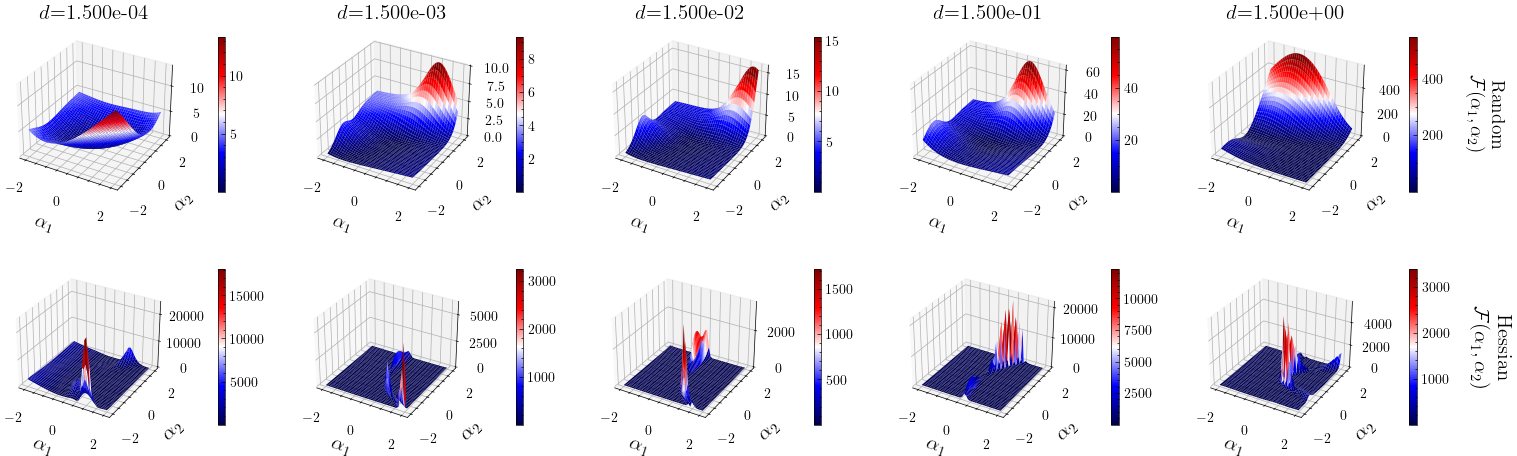

In [20]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(18, 15), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in enumerate(PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    clr_bar1 = fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.10, orientation='vertical', pad=0.15)

    if idx == len(PARAM_LIST) - 1:
        clr_bar1.set_label(
            "Random\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=14,
            rotation=-90,
            labelpad=45
        )

    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    # if idx == 0:
    #     ax[0, idx].set_zlabel("Random", labelpad=-90)
    #     ax[0, idx].zaxis.label.set_rotation(90)

    if TOP_PLOT:
        ax[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    clr_bar2 = fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.10, orientation='vertical', pad=0.2)

    if idx == len(PARAM_LIST) - 1:
        clr_bar2.set_label(
            "Hessian\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=15,
            rotation=-90,
            labelpad=45
        )
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15, labelpad=1.1)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)
    # ax[1, idx].set_zlim(vmin, vmax)

fig.subplots_adjust(left=0.1, right=0.9, hspace=-0.85, top=1.3)

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"pinn/loss_landscape_random_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

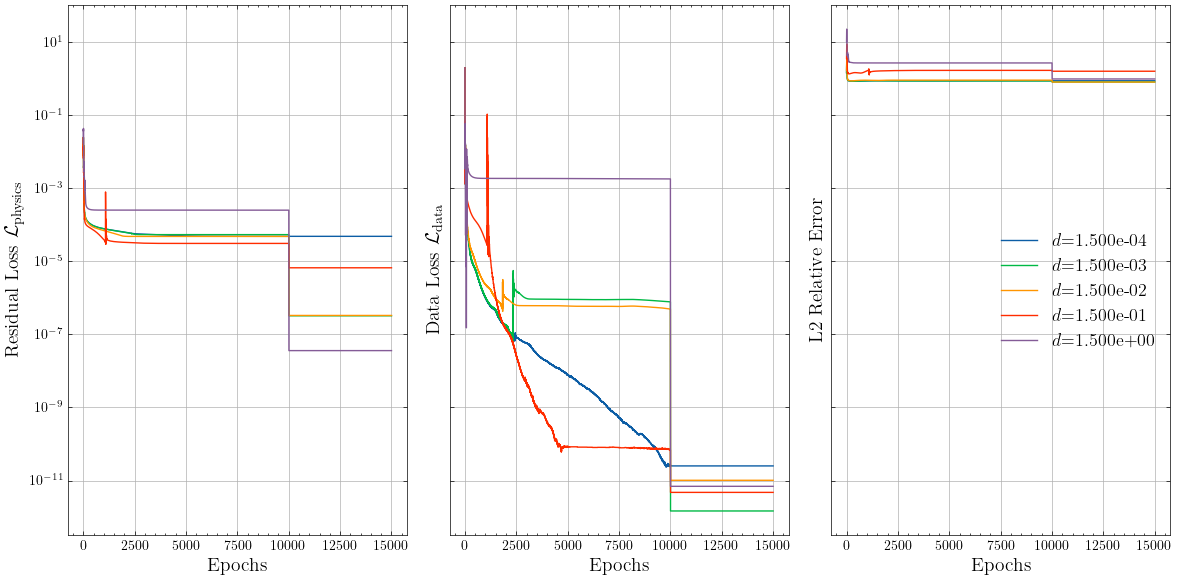

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

# Plot the random direction vector subspace projection of the loss landscape
for residual_loss, init_loss, param, l2_relative in zip(residual_losses_per_param, IC_losses_per_param, PARAM_LIST, test_losses_per_param_per_epoch):
    
    ax[0].semilogy(range(1, EPOCHS+1), residual_loss, label=f"{VARYING_PARAM_NOTATION}={param:.3e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel(r"Residual Loss $\mathcal{L}_{\mathrm{physics}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[0].grid()

    ax[1].semilogy(range(1, EPOCHS+1), init_loss, label=f"{VARYING_PARAM_NOTATION}={param:.3e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel(r"Data Loss $\mathcal{L}_{\mathrm{data}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[1].grid()

    ax[2].semilogy(range(1, EPOCHS+1), l2_relative, label=f"{VARYING_PARAM_NOTATION}={param:.3e}")
    ax[2].set_xlabel("Epochs", fontsize=14)
    ax[2].set_ylabel("L2 Relative Error", fontsize=14)
    ax[2].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[2].grid()

plt.tight_layout()

# # Output the plots as PDF to the desired directory
# loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

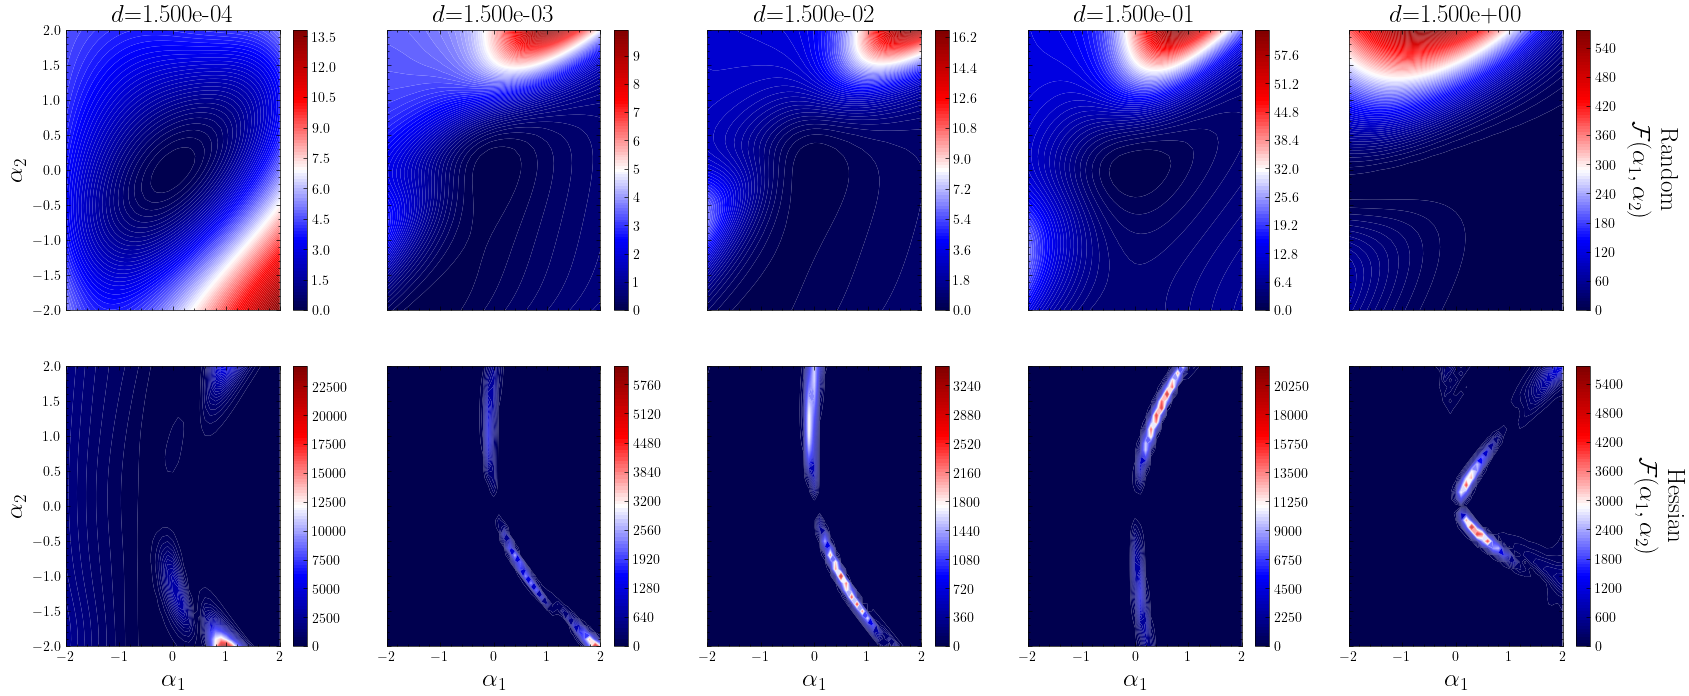

In [22]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

for index, (param) in enumerate(PARAM_LIST):
    contour_random = ax[0, index].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )

    clr_bar1 = fig.colorbar(contour_random, ax=ax[0, index], shrink=1, orientation='vertical', pad=0.05)

    if index == len(PARAM_LIST) - 1:
        clr_bar1.set_label(
            "Random\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=18,
            rotation=-90,
            labelpad=45
        )
    
    if index == 0:
        ax[0, index].set_ylabel(r'$\alpha_2$', fontsize=18)
        ax[1, index].set_ylabel(r'$\alpha_2$', fontsize=18)

    if TOP_PLOT:
        ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=18)


    contour_hessian = ax[1, index].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )

    clr_bar2 = fig.colorbar(contour_hessian, ax=ax[1, index], shrink=1, orientation='vertical', pad=0.05)

    if index == len(PARAM_LIST) - 1:
        clr_bar2.set_label(
            "Hessian\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=18,
            rotation=-90,
            labelpad=45
        )
    
    ax[1, index].set_xlabel(r'$\alpha_1$', fontsize=18)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"pinn/contour_random_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:56: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:56: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_10025/3616472978.py:56: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_10025/3616472978.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


Pred vector shape: torch.Size([2, 201])
Label vector shape: torch.Size([2, 201])
Test times shape: torch.Size([201, 1])
$d$: 0.00015
L2 absolute error: 6.69
L2 relative error: 89.18

$d$: 0.0015
L2 absolute error: 6.20
L2 relative error: 82.53

$d$: 0.015
L2 absolute error: 4.98
L2 relative error: 82.14

$d$: 0.15
L2 absolute error: 3.22
L2 relative error: 162.69

$d$: 1.5
L2 absolute error: 2.28
L2 relative error: 99.87



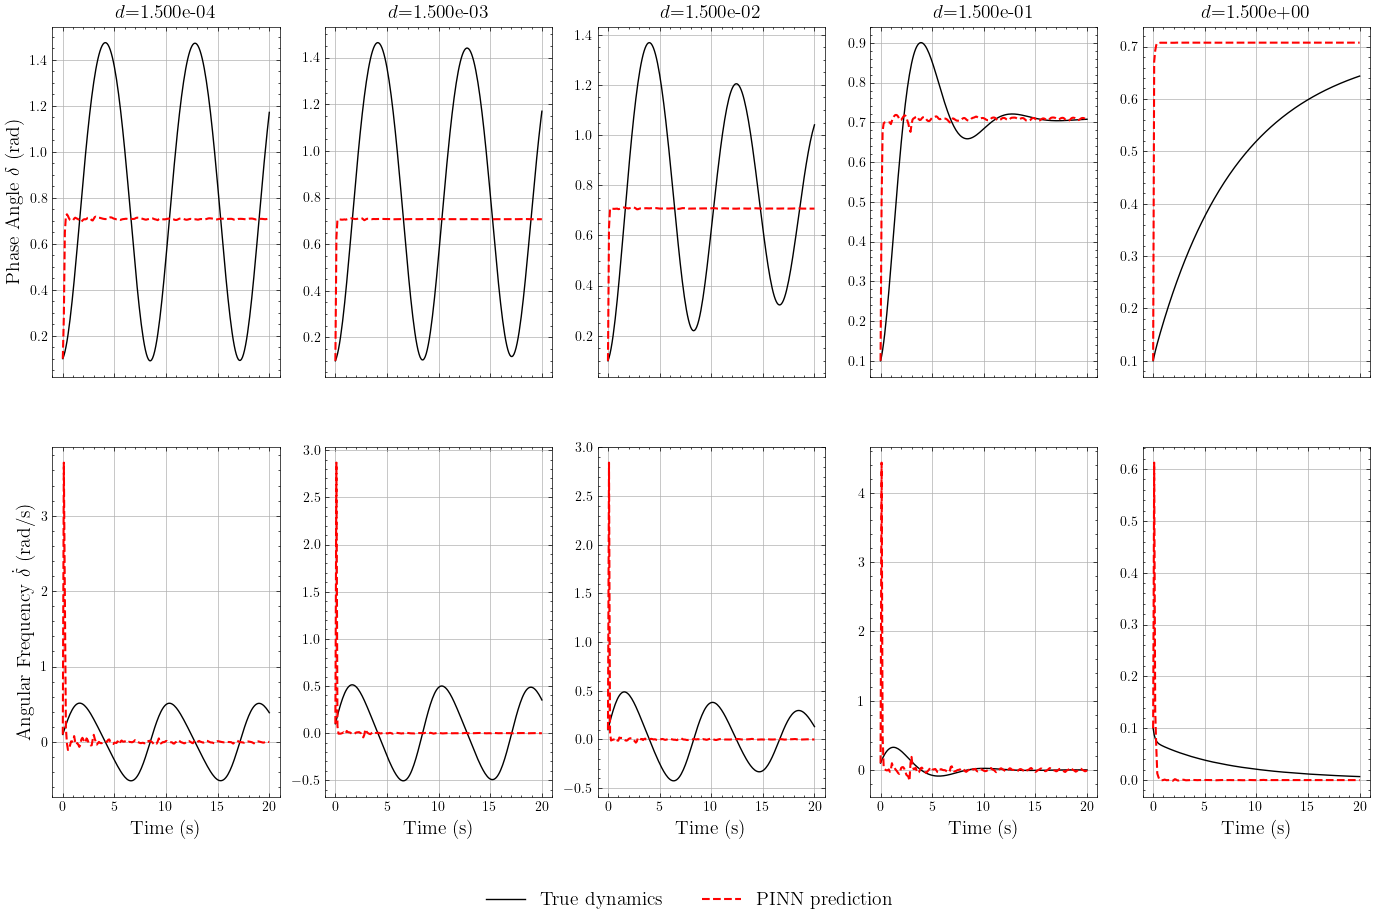

In [23]:
abs_errors_pinns = []
rel_errors_pinns = []
pinn_predictions_per_param = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]
    angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

    times_tensor_FFE = FFE(original_input=times_tensor, frequency_vector=feature_vector)

    pinn = model
    pinn.eval()
    pred = pinn.forward(data=times_tensor_FFE)
    pred_dot = torch.autograd.grad(
        outputs=pred,
        inputs=times_tensor,
        grad_outputs=torch.ones_like(pred),
        create_graph=False,
        retain_graph=True
    )[0]

    pred_vector = torch.stack(tensors=(pred, pred_dot), dim=0).squeeze()
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    if index == 0:
        print(f"Pred vector shape: {pred_vector.shape}")
        print(f"Label vector shape: {label_vector.shape}")
        print(f"Test times shape: {times_tensor.shape}")

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"{VARYING_PARAM_NOTATION}: {param}")
    print(f"L2 absolute error: {l2_abs:.2f}")
    print(f"L2 relative error: {l2_rel*100:.2f}\n")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)
    pinn_predictions_per_param.append(pred_vector.detach().numpy())

    ax[0, index].plot(numerical_domain, phase_angle_labels, color="black", linestyle="-", label="True dynamics")
    ax[0, index].plot(numerical_domain, pred.detach().numpy(), color='red', linestyle='--', label='PINN prediction', linewidth=1.5)
    ax[0, index].grid()
    # ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=14)

    ax[1, index].plot(numerical_domain, angular_frequency_labels, color="black", linestyle="-", label="True dynamics")
    ax[1, index].plot(numerical_domain, pred_dot.detach().numpy(), color='red', linestyle='--', label='PINN prediction', linewidth=1.5)
    ax[1, index].grid()
    # ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=14)

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    exact_vs_pred_image: str = f"pinn/pinn_vs_ground_truth_seed_{SEED}.pdf"
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

# if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is True) and (DATA_LOSS is False):
#     print("Saving adaptive weight plot...")
#     exact_vs_pred_image: str = f"pinn/pinn_vs_ground_truth_seed_adaptive_wang_2020_seed_{SEED}.pdf"
#     plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

In [24]:
type(pred.grad_fn)

MmBackward0

In [25]:
print(f"Table of relative errors (%) of seed {SEED} and param {VARYING_PARAM} (columns):\n\n{[rel_error.item()*100 for rel_error in rel_errors_pinns]}\n")

Table of relative errors (%) of seed 0 and param damping (columns):

[89.17660713195801, 82.52756595611572, 82.14066624641418, 162.6917839050293, 99.8706042766571]



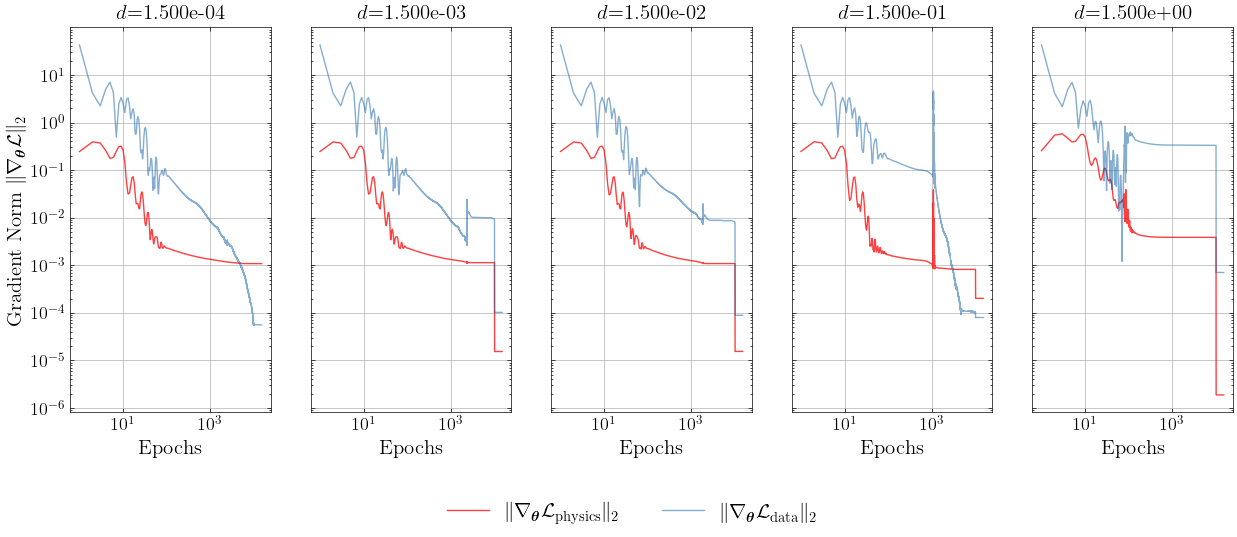

In [26]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):
    axes[idx].loglog(range(1, EPOCHS+1), grad_norm_res_per_param[idx], color="red", alpha=0.75, label=r"$\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}\rVert_{2}$")
    axes[idx].loglog(range(1, EPOCHS+1), grad_norm_data_per_param[idx], alpha=0.5, label=r"$\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}\rVert_{2}$")
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)
    axes[idx].set_xlabel("Epochs", fontsize=15)
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 


    if idx == 0:
        axes[idx].set_ylabel(r"Gradient Norm $\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}\rVert_{2}$", fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), fontsize=15)

residual_norm_vs_data_norm: str = f"pinn/residual_norm_vs_data_norm_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+residual_norm_vs_data_norm, format="pdf", bbox_inches="tight")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 11x10)

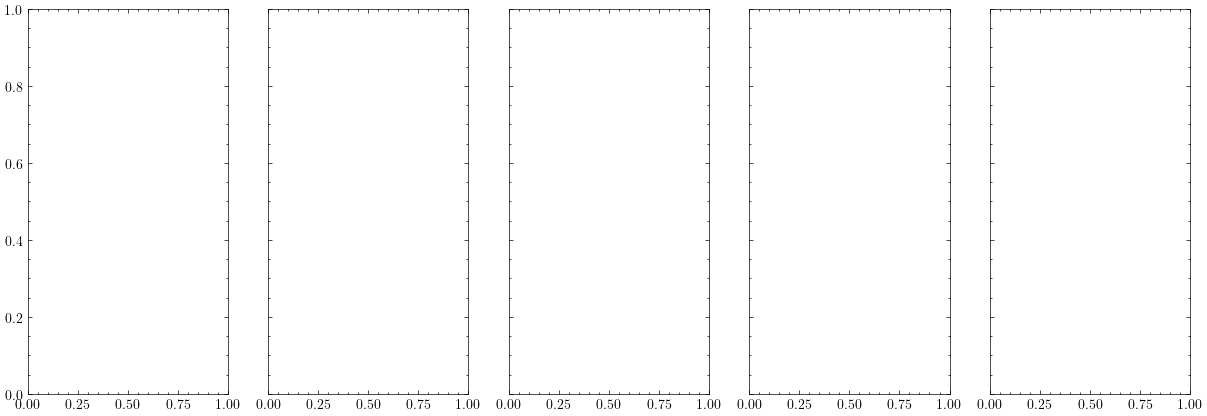

In [27]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    pinn = pinn_models[idx]
    
    pinn.eval()
    residual_loss = np.array([physics_based_loss(model=pinn, input=test.clone().detach().requires_grad_(True)).item() for test in times_tensor])
    # skewness_val = skew(a=residual_loss)
    # kurtosis_val = kurtosis(a=residual_loss, fisher=True)

    # print(f"Skewness={skewness_val}\nKurtosis={kurtosis_val}")

    axes[idx].semilogy(times_tensor.detach().numpy(), residual_loss)
    axes[idx].set_xlabel('Time (s)', fontsize=15)
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 


    if idx == 0:
        axes[idx].set_ylabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$', fontsize=15)
        # axes[1, idx].set_ylabel("Frequency")

    # axes[1, idx].hist(residual_loss, log=False)
    # axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

residual_fields: str = f"pinn/residual_fields_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+residual_fields, format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5))

for idx, param in enumerate(PARAM_LIST):
    # axes_twin = axes[idx].twinx()

    axes[idx].loglog(range(1, EPOCHS+1), test_losses_per_param_per_epoch[idx], label="$L_{2}$ Relative Error")
    axes[idx].set_xlabel('Epochs', fontsize=16)
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
    axes[idx].loglog(range(1, EPOCHS+1), residual_losses_per_param[idx], color="red", label="$\mathcal{L}_{\mathrm{physics}}$")
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 

    # axes[idx].xaxis.set_major_formatter(ScalarFormatter())
    # axes[idx].ticklabel_format(axis="x", style="sci", scilimits=(3,3))

    if idx == 0:
        axes[idx].set_ylabel(r'Error', fontsize=16)
        # axes[1, idx].set_ylabel("Frequency")

    # axes[1, idx].hist(residual_loss, log=False)
    # axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), fontsize=16)
plt.tight_layout()

l2_rel_error_vs_residual_loss: str = f"pinn/l2_rel_error_vs_residual_loss_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+l2_rel_error_vs_residual_loss, format="pdf", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, param in enumerate(PARAM_LIST):
    # axes_twin = axes[idx].twinx()

    axes[0].semilogy(range(1, EPOCHS+1), test_losses_per_param_per_epoch[idx])
    axes[0].set_xlabel('Epochs')
    axes[0].grid()

    axes[1].semilogy(range(1, EPOCHS+1), residual_losses_per_param[idx], label="$\mathcal{L}_{\mathrm{physics}}$")

    axes[0].xaxis.set_major_formatter(ScalarFormatter())
    axes[0].ticklabel_format(axis="x", style="sci", scilimits=(3,3))

    axes[1].xaxis.set_major_formatter(ScalarFormatter())
    axes[1].ticklabel_format(axis="x", style="sci", scilimits=(3,3))

    if idx == 0:
        axes[idx].set_ylabel(r'$L_{2}$ Relative Error')
        # axes[1, idx].set_ylabel("Frequency")

    # axes[1, idx].hist(residual_loss, log=False)
    # axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

test_error: str = f"{VARYING_PARAM}_l2_test_error_random_seed_{SEED}.pdf"


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for (param, res_loss) in zip(PARAM_LIST, residual_losses_per_param):
    ax.semilogy(
        range(1, EPOCHS+1),
        res_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax.set_ylabel("Residual loss $\mathcal{L}_{\mathrm{physics}}$", fontsize=12)
ax.set_xlabel("Epochs", fontsize=12)
ax.grid()
ax.legend(loc="best", fontsize=12, bbox_to_anchor=(1.3, 0.6), borderaxespad=0.12)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# if SAVE:
#     plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for param, grad_norm in zip(PARAM_LIST, gradient_norm_per_param):
    ax.semilogx(
        range(1, EPOCHS_ADAM+1),
        grad_norm,
        label=f"{VARYING_PARAM_NOTATION}={param:.3e}",
        alpha=0.8
    )

ax.set_ylabel(r"Gradient Norm $\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}\rVert_{2}$", fontsize=15)
ax.set_xlabel("Epochs (Adam)", fontsize=15)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(PARAM_LIST), bbox_to_anchor=(0.525, -0.08), fontsize=15)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(18, 6))
for idx, param in enumerate(PARAM_LIST):

        ax[idx].loglog(
            range(1, EPOCHS+1),
            IC_losses_per_param[idx],
            alpha=0.7,
            label="Data loss $\mathcal{L}_{\mathrm{data}}$"
        )

        ax[idx].loglog(
            range(1, EPOCHS+1),
            residual_losses_per_param[idx],
            color="red",
            alpha=0.7,
            label="Residual loss $\mathcal{L}_{\mathrm{physics}}$"
        )

        if idx == 0:
            ax[idx].set_ylabel("Training Loss", fontsize=16)

        ax[idx].set_xlabel("Epochs", fontsize=16)
        ax[idx].grid()
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.1e}", fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08), fontsize=16)

In [ ]:
abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

errors_output = f"pinn/l2_errors/abs_rel_errors_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)

In [ ]:
if DATA_LOSS:
    abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
    rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

    errors_output = f"pinn/l2_errors/semi_supervised/semi_supervised_abs_rel_errors_seed_{SEED}_Nd_{rand_index.shape[0]}.npz"
    
    np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)

In [ ]:
training_loss_output = f"pinn/training_loss/training_loss_per_epoch_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+training_loss_output,
        total_loss=np.array(training_losses_per_param),
        residual_loss=np.array(residual_losses_per_param),
        data_loss=np.array(IC_losses_per_param)
    )

In [ ]:
test_loss_output = f"pinn/rel_error_per_epoch/rel_errors_per_epoch_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+test_loss_output,
        test_loss=np.array(test_losses_per_param_per_epoch)
    )

In [ ]:
pinn_predictions_vs_rk45 = f"pinn/pinn_pred_vs_rk45/pinn_pred_vs_rk45_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+pinn_predictions_vs_rk45,
        pred=np.array(pinn_predictions_per_param)[:, 0, :],
        pred_dot=np.array(pinn_predictions_per_param)[:, 1, :]
    )

In [ ]:
loss_grad_norms = f"pinn/gradient_norms/loss_grad_norm_per_epoch_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+loss_grad_norms,
        grad_norms=np.array(gradient_norm_per_param)
    )

In [ ]:
np.array(ESD_LIST[0][0]).flatten().shape

In [ ]:
fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5))

for idx, param in enumerate(PARAM_LIST):
    density, grids = density_generate(ESD_LIST[idx][0], ESD_LIST[idx][1])

    max_eigenvalue = np.abs(grids).max()
    min_eigenvalue = np.abs(grids).min()

    print(max_eigenvalue)
    print(min_eigenvalue)

    condition_number = max_eigenvalue / min_eigenvalue

    ax[idx].semilogy(grids, density + 1.0e-7, label=f"$\kappa$={condition_number:.2f}")

    if idx == 0:
        ax[idx].set_ylabel('Density', fontsize=14, labelpad=10)

    ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.1e}", fontsize=14)
    ax[idx].set_xlabel('Eigenvalue Magnitudes', fontsize=14, labelpad=10)
    ax[idx].legend(loc="best")
    # ax[idx].yticks(fontsize=12)
    # ax[idx].axis([np.min(ESD_LIST[idx][0]) - 1, np.max(ESD_LIST[idx][0]) + 1, None, None])

plt.tight_layout()

In [ ]:
print(f"Seed: {SEED}\tParameter: {VARYING_PARAM}")
for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Model {index+1}")
    print("----------------------\n")

    MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[param]])

    supervised_mse = torch.nn.MSELoss()

    # Place PINN in evaluation mode
    model.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(model.parameters()).clone().detach()

    vector_to_parameters(vec=initial_params_pinn_models, parameters=model.parameters())

    if R3_ALGO:
        loss_func = loss_closure(model=model, input=collocation_points_R3[index], initial_state=INITIAL_STATE)
        hessian_comp = hessian(model, loss_func, data=(collocation_points_R3[index], numerical_solutions_exact), cuda=False)
    else:
        loss_func = loss_closure(model=model, input=collocation_points, initial_state=INITIAL_STATE)
        hessian_comp = hessian(model, loss_func, data=(collocation_points, numerical_solutions_exact), cuda=False)

    top_eigenvalue, _ = hessian_comp.eigenvalues(top_n=1)

    print(f"{VARYING_PARAM_NOTATION}={param}: {top_eigenvalue}\n")
    vector_to_parameters(vec=MINIMISER, parameters=model.parameters())

In [ ]:
if ADAPTIVE_ALGO:
    fig, axes = plt.subplots(2, len(PARAM_LIST), figsize=(15, 5))

    for idx, (weight, mean_grad, max_grad) in enumerate(zip(adaptive_weights_per_n_epochs_per_param, mean_gradients_per_param, max_gradients_per_param)):

        axes[0, idx].loglog(range(1, EPOCHS_ADAM+1, 10), mean_grad, label=r"$\overline{|\nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathrm{physics}}|}$")
        axes[0, idx].loglog(range(1, EPOCHS_ADAM+1, 10), max_grad, color="g", label=r"$\max_{\boldsymbol{\theta}}\Big\{|\nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathrm{data}}|\Big\}$")
        axes[0, idx].grid()
        axes[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{PARAM_LIST[idx]:.3e}", fontsize=16)
        axes[0, idx].tick_params(axis="both", which="major", labelsize=11)
        
        axes[1, idx].loglog(range(1, EPOCHS_ADAM+1), [lambda_physics[0] for lambda_physics in weight], label=r"$\lambda_{\mathrm{physics}}$", color="red") 
        axes[1, idx].legend(fontsize=16)
        axes[1, idx].set_xlabel("Epochs", fontsize=16)
        axes[1, idx].grid()
        axes[1, idx].tick_params(axis="both", which="major", labelsize=11) 

        if idx == 0:
            axes[0, idx].set_ylabel("Magnitude", fontsize=16)
            axes[1, idx].set_ylabel("Magnitude", fontsize=16)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.18), fontsize=14)
    plt.tight_layout()

    if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is True) and (DATA_LOSS is False):
        print("Saving adaptive weight plot...")
        adpative_weight_diagnosis: str = f"pinn/adaptive_diagnosis_wang_2020_seed_{SEED}.pdf"
        plt.savefig(fname=PATH_TO_IM_DIR+adpative_weight_diagnosis, format="pdf", bbox_inches="tight")

In [ ]:
if ADAPTIVE_ALGO:
    fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5))

    for idx, (weight) in enumerate(adaptive_weights_per_n_epochs_per_param):

        axes[idx].loglog(range(1, EPOCHS_ADAM+1), [lambda_physics[0] for lambda_physics in weight], label=r"$\lambda_{\mathrm{physics}}$", color="red") 
        axes[idx].loglog(range(1, EPOCHS_ADAM+1), [lambda_physics[1] for lambda_physics in weight], label=r"$\lambda_{\mathrm{data}}$") 
        axes[idx].set_xlabel("Epochs", fontsize=16)
        axes[idx].grid()
        axes[idx].tick_params(axis="both", which="major", labelsize=11) 

        if idx == 0:
            axes[idx].set_ylabel("Magnitude", fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.18), fontsize=16)
    plt.tight_layout()

    if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is True) and (DATA_LOSS is False):
        print("Saving adaptive weight plot...")
        adpative_weight_diagnosis: str = f"pinn/adaptive_diagnosis_wang_2023_seed_{SEED}.pdf"
        plt.savefig(fname=PATH_TO_IM_DIR+adpative_weight_diagnosis, format="pdf", bbox_inches="tight")

In [ ]:
optimiser_adam.zero_grad()
res_loss = physics_based_loss(pinn_models[0], input=collocation_points.clone().detach().requires_grad_(True))
print(res_loss)
res_loss.backward()

w_n_b_per_layer_res = {}

for name, w_n_b in pinn_models[0].named_parameters():
    if w_n_b.grad is not None:
        param_grad = w_n_b.grad.detach().clone().numpy().flatten()
        w_n_b_per_layer_res[name] = param_grad


optimiser_adam.zero_grad()
ic_loss = IC_based_loss(model=pinn_models[0], initial_state=INITIAL_STATE, device=DEVICE)
print(ic_loss)
ic_loss.backward()

w_n_b_per_layer_ic = {}

for name, w_n_b in pinn_models[0].named_parameters():
    if w_n_b.grad is not None:
        param_grad = w_n_b.grad.detach().clone().numpy().flatten()
        w_n_b_per_layer_ic[name] = param_grad

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.hist(w_n_b_per_layer_res["PINN.14.weight"], alpha=1.0, color="blue")
ax.hist(w_n_b_per_layer_ic["PINN.14.weight"], alpha=0.6, color='red')

In [ ]:
w_n_b_per_layer_ic["PINN.3.weight"]

In [ ]:
w_n_b_per_layer_res["PINN.3.weight"]

In [ ]:
def R3_algorithm(collocation_set: torch.Tensor, model: Callable, n: int, epoch: int, **kwargs) -> torch.Tensor:
        
    """
    Implements the R3 (retain-release-resample) sampling algorithm proposed by Daw
    et al. 2023 (https://arxiv.org/abs/2207.02338).
    """

    assert collocation_set.requires_grad is True

    if epoch % n == 0:
        residual_array = []

        model.eval()

        for t in collocation_set:
            t_fresh = t.clone().detach().requires_grad_(True)  # New leaf node with grad
            residual = physics_based_loss(model=model, input=t_fresh)
            print(torch.abs(residual).detach())
            residual_array.append(torch.abs(residual).detach().item())
            
        residual_tensor = torch.stack(residual_array)
        threshold = torch.mean(residual_tensor)
        print(f"Threshold: {threshold}")

        # Retain points above threshold
        retained = collocation_set[residual_tensor > threshold]
        retained = retained.clone().detach().requires_grad_(True)
        print(retained)
        print(retained.shape)

        # Resample new ones
        n_to_sample = N_C - retained.shape[0]
        new_samples = (T0 - FINALTIME) * torch.rand((n_to_sample, 1), device=DEVICE, requires_grad=True) + FINALTIME

        collocation_next_epoch = torch.cat([retained, new_samples], dim=0)
        collocation_next_epoch = collocation_next_epoch.clone().detach().requires_grad_(True)  # Final safety

        # print(collocation_set)
        # print(threshold)
        # print(residual_tensor)
        # print(retained)
        # print(collocation_next_epoch)

        assert collocation_next_epoch.shape == (N_C, 1)
        assert collocation_next_epoch.requires_grad is True
        
        model.train()
        return collocation_next_epoch, retained, new_samples
    else:
        return collocation_set

In [ ]:
_, p_retain, p_resample = R3_algorithm(collocation_set=collocation_points, model=pinn_models[-2], n=1, epoch=1)

In [ ]:
test_pinn = pinn_models[-2]
test_res_loss = [physics_based_loss(model=test_pinn, input=colloc).detach().item() for colloc in collocation_points]
plt.scatter(collocation_points.detach().numpy(), test_res_loss)

In [ ]:
plt.scatter(collocation_points.detach().numpy(), np.zeros_like(collocation_points.detach().numpy()), marker="x")
# plt.scatter(
#     p_resample.detach().numpy(),
#     np.zeros_like(p_resample.detach().numpy()),
#     marker=".",
#     alpha=0.2,
#     color='r'
# )
plt.scatter(
    p_retain.detach().numpy(),
    np.zeros_like(p_retain.detach().numpy()),
    marker=".",
    alpha=0.2
)

print(p_resample.shape)
print(p_retain.shape)

In [ ]:
x = torch.ones(3, requires_grad=True)
y = x.detach()
y[0] = 42   # also changes x[0]!
print(x)    # tensor([42., 1., 1.], grad_fn=<CopyBackwards>)

In [ ]:
x = torch.ones(3, requires_grad=True)
y = x.clone().detach()
y[0] = 42   # also changes x[0]!
print(x)    # tensor([42., 1., 1.], grad_fn=<CopyBackwards>)

In [ ]:
test_tensor = torch.tensor(data=[[1.0, 2.0, 3.0]], dtype=torch.float32, requires_grad=True).T
print(physics_based_loss(model=pinn_models[0], input=test_tensor.clone().detach().requires_grad_(True)))

vectorised = torch.vmap(physics_based_loss, in_dims=(None, 0))

print(vectorised(pinn_models[0], test_tensor.clone().detach().requires_grad_(True)))